Titanic Exploration using ForML
===============================

ForML framework allows to implement an ML solution using formalized project components and their structured packaging. This is great for automated project lifecycle management but less suitable for [interactive exploration](../../interactive.rst) typical for Jupyter. This notebook will demonstrate the ForML-Jupyter interoperability designed specifically for this methodology.

Let's assume our project has now the following structure with this notebook under its `notebooks` folder:

    $ tree forml-tutorial-titanic
    forml-tutorial-titanic
    ├── notebooks
    │   └── exploration.ipynb  # this notebook!
    ├── titanic
    │   ├── __init__.py
    │   ├── evaluation.py
    │   ├── pipeline.py
    │   └── source.py
    └── setup.py


Obtaining the Project Handle
----------------------------
Given the existing project structure, we can now grab the *programmatic handle* to our project using the `project.open()` function:

In [1]:
import io
import sys

import numpy as np
import pandas as pd

from forml import project
from forml.pipeline import wrap

PROJECT_PATH = '..'  # parent directory is the project root
sys.path.insert(0, PROJECT_PATH)  # making our project visible to the Jupyter kernel

PROJECT = project.open(path=PROJECT_PATH, package='titanic')

Exploring the Source Data
-------------------------

We start with reusing the `source` component as defined in our initialized project and running it through a custom *stateless transformer operator* for returning the `pandas.DataFrame.info()` from the particular dataset. We interactively execute the `.apply()` action using the `.launcher` property on the bound pipeline instance retrieving its result:

In [2]:
SOURCE = PROJECT.components.source


@wrap.Operator.mapper
@wrap.Actor.apply
def info(df: pd.DataFrame):
    """Custom operator returning the DataFrame.info()"""
    with io.StringIO() as buf:
        df.info(buf=buf)
        return buf.getvalue()


print(SOURCE.bind(info()).launcher.apply())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Fare      417 non-null    float64
 7   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB



Exploring the *labeled trainset* is slightly more involved as normally the *train-mode* by design doesn't produce any output. The interactive launcher, however, captures both the *features* as well as the *outcomes* segment outputs allowing to access their values:

In [3]:
print(SOURCE.bind(info()).launcher.train().features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB



Imputing Missing Values
-----------------------

Given the insight details above, let's implement a *stateful operator* for imputing the missing values for the `Age`, `Fare` and `Embarked` columns:

In [4]:
@wrap.Actor.train
def Impute(state, X, y, random_state=None) -> dict[str, float]:
    """Train part of a stateful transformer for missing values imputation."""
    return {'age_mean': X['Age'].mean(), 'age_std': X['Age'].std()}


@wrap.Operator.mapper
@Impute.apply
def Impute(state: dict[str, float], X, random_state=None) -> pd.DataFrame:
    """Apply part of a stateful transformer for missing values imputation."""
    na_slice = X['Age'].isna()
    if na_slice.any():
        rand_age = np.random.default_rng(random_state).integers(
            state['age_mean'] - state['age_std'], state['age_mean'] + state['age_std'], size=na_slice.sum()
        )
        X.loc[na_slice, 'Age'] = rand_age  # random age with same distribution
    X['Embarked'].fillna('S', inplace=True)  # assuming Southampton
    X['Fare'].fillna(X['Fare'].mean(), inplace=True)  # mean fare
    return X.drop(columns='Name')


PIPELINE = Impute(random_state=42)

EXPERIMENT1 = SOURCE.bind(PIPELINE)
EXPERIMENT1.launcher.train()
EXPERIMENT1.launcher.apply()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,39.0,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,33.0,0,0,8.0500,S


Baseline Workflow
-----------------

Let's now create our simple baseline model workflow as a reference for further improvements in the scope of the followup implementation. We import the `OneHotEncoder` and `RandomForestClassifier` from Sklearn under the `wrap.importer` context to auto-turn it into ForML operators and attach it to the initial pipeline.

To explore the runtime graph, we execute it using the `graphviz` runner:

In [5]:
with wrap.importer():
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import OneHotEncoder

PIPELINE >>= OneHotEncoder(handle_unknown='infrequent_if_exist', sparse=False) >> RandomForestClassifier(
    random_state=42
)

SOURCE.bind(PIPELINE).launcher['visual'].train()

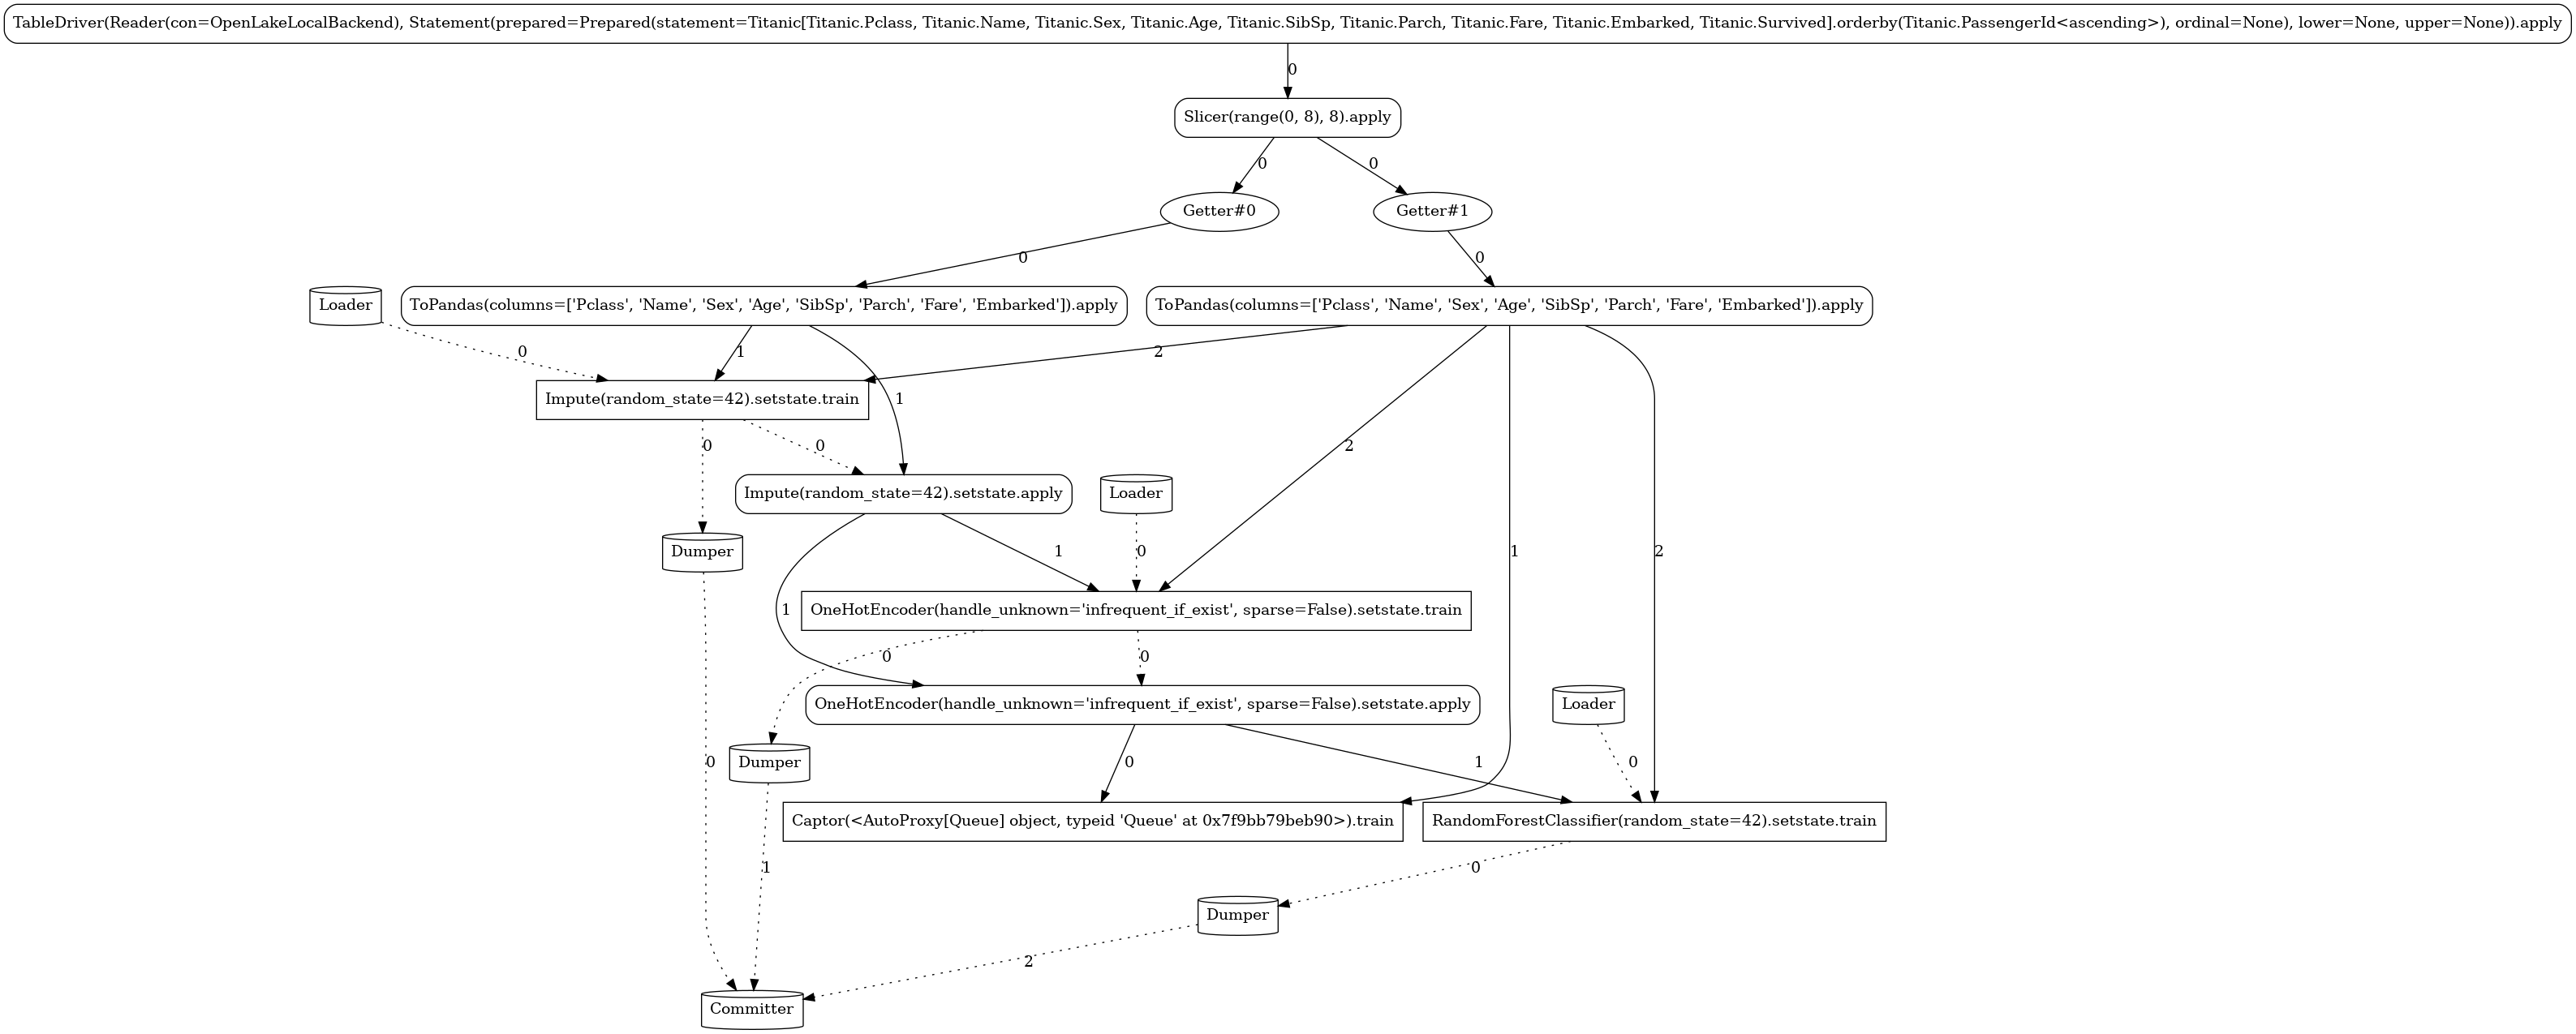

Evaluation
----------

Finally, let's run this our simple pipeline through the project-defined evaluation method to get the baseline accuracy score:

In [6]:
SOURCE.bind(PIPELINE, evaluation=PROJECT.components.evaluation).launcher.eval()

0.7821229050279329

That's it for our brief exploration. Based on this initial results, we will continue to implement the actual solution as a native ForML project and let's see how much we can improve from our baseline.